[header stuff here]


# 01: EDA
---

Start by importing a few important libraries:

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime

In [2]:
crime = pd.read_csv('../data/crimes_by_state.csv')

In [3]:
crime.head()

,state_abbr,year,population,violent_crime,homicide,rape,robbery,aggravated_assault,property_crime,burglary,...,violent_crime_1000,homicide_1000,rape_1000,robbery_1000,aggravated_assault_1000,property_crime_1000,burglary_1000,larceny_1000,motor_vehicle_theft_1000,arson_1000
0,AL,1979,3769000,15578,496,1037,4127,9918,144372,48517,...,4.133192,0.131600,0.275139,1.094985,2.631467,38.305121,12.872645,22.231626,3.200849,0.067392
1,AL,1980,3861466,17320,509,1158,5102,10551,173191,58952,...,4.485343,0.131815,0.299886,1.321260,2.732382,44.851101,15.266741,26.422348,3.162012,0.287197
2,AL,1981,3916000,18423,465,1021,4952,11985,173411,56811,...,4.704545,0.118744,0.260725,1.264556,3.060521,44.282686,14.507406,26.933350,2.841931,0.305158
3,AL,1982,3943000,17653,417,1026,4417,11793,165048,49531,...,4.477048,0.105757,0.260208,1.120213,2.990870,41.858483,12.561755,26.563530,2.733198,0.273396
4,AL,1983,3959000,16471,364,931,3895,11281,145890,42485,...,4.160394,0.091942,0.235160,0.983834,2.849457,36.850215,10.731245,23.813842,2.305128,0.247790


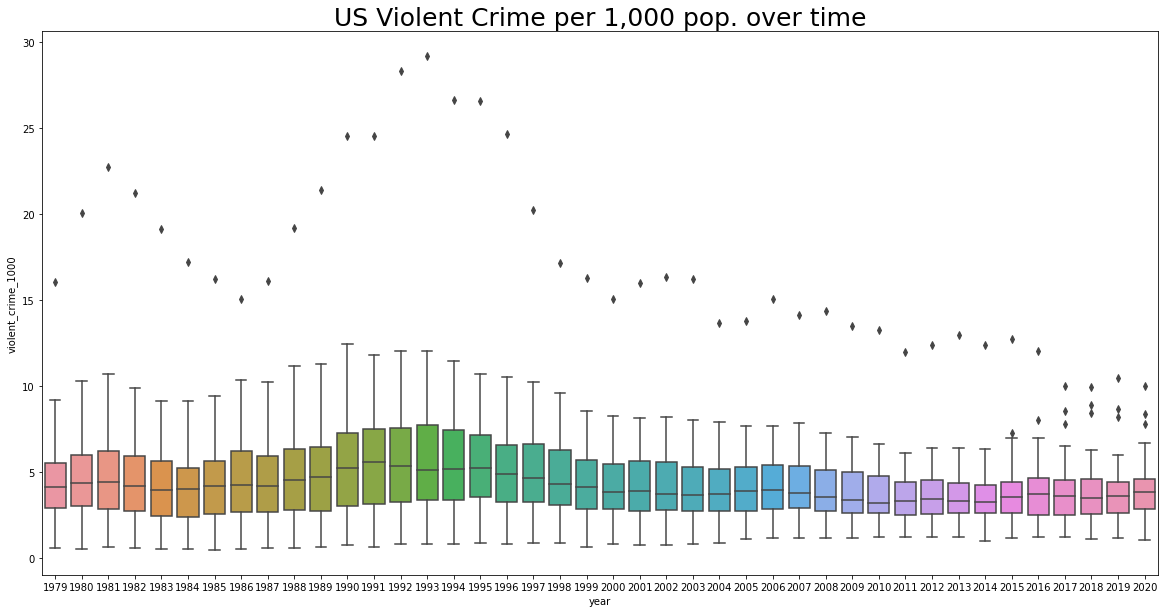

In [13]:
plt.figure(figsize=(20,10))
plt.title('US Violent Crime per 1,000 pop. over time',size=25)
sns.boxplot(x='year',
            y=crime['violent_crime_1000'],
            data=crime);

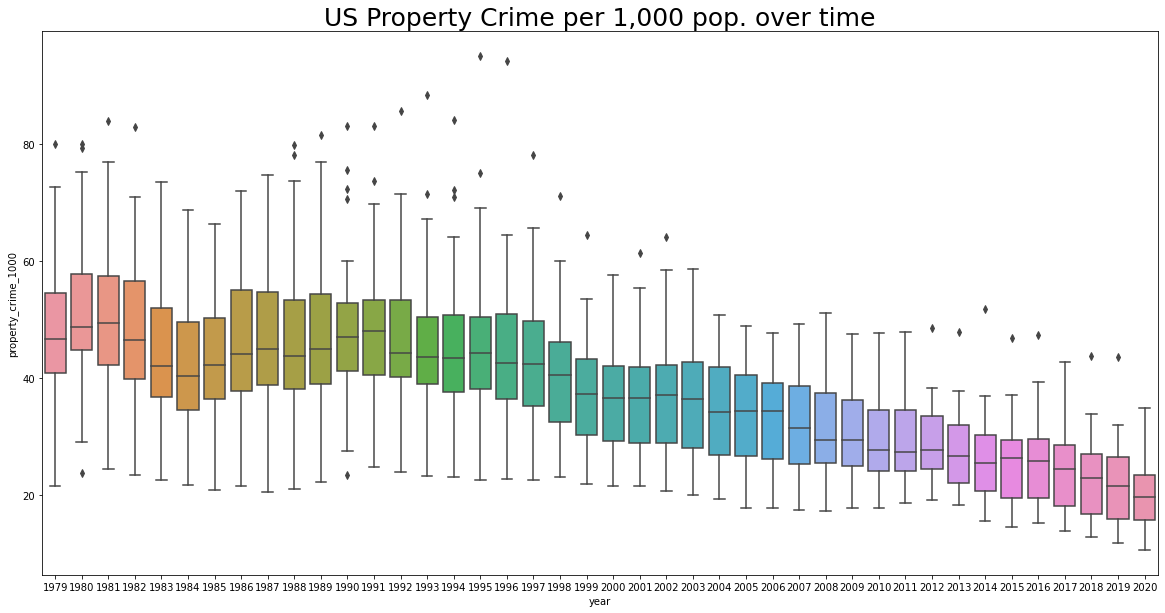

In [12]:
plt.figure(figsize=(20,10))
plt.title('US Property Crime per 1,000 pop. over time', size = 25)
sns.boxplot(x='year',
            y=crime['property_crime_1000'],
            data=crime);